In [1]:
import sys

sys.path.insert(0, "../")

import fiftyone as fo
from fiftyone import ViewField as F

from yolotrt.yolotrt import YoloTRT
from horizon.dataloaders import get_val_rgb_dataloader

dataset_name = "SAILING_DATASET_RGB_2023_10"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 1280

dataloader = get_val_rgb_dataloader(
    dataset=(
        fo.load_dataset(dataset_name)
        .match(F("ground_truth_pl.polylines.closed") == [False])
        .match_tags(val_tag)
        # .match(F("trip") == "Trip_306")
        # .take(5000, seed=51)
    ),
    imgsz=imgsz,
    batch_size=1,
    num_workers=0,
    shuffle=True,
)

ahoy_trt = YoloTRT(
    trt_engine_path="./ahoy.engine",
    img_size=imgsz,
)

Loading TensorRT inference engine ./ahoy.engine
  * Max batch size - 1



 26.6 ms - full


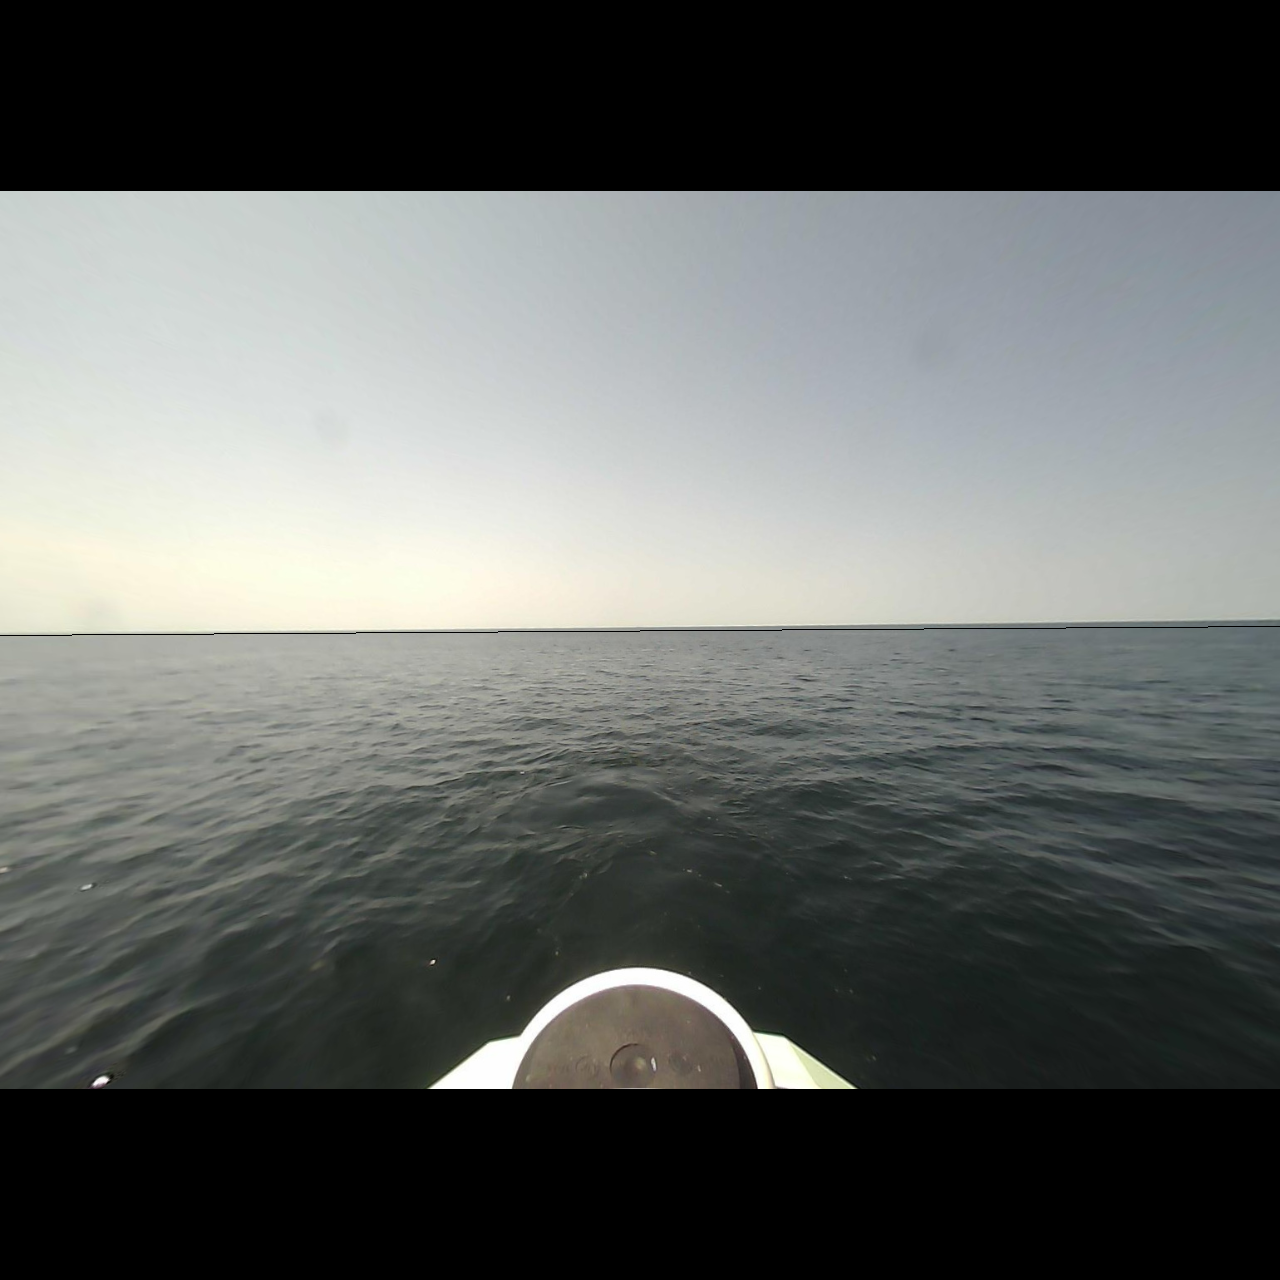

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image

from horizon.utils import draw_horizon, draw_bboxes
from yolotrt.misc import Profile

for image, target in dataloader:
   break


def postprocess_x_pitch_theta(x_pitch, x_theta):
    # curve fitting
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

    # Initial guess for the parameters (amplitude, mean, standard deviation)
    pitch0 = [x_pitch.max(), x_pitch.argmax() / x_pitch.shape[-1], 0.001]
    theta0 = [x_theta.max(), x_theta.argmax() / x_theta.shape[-1], 0.001]

    x_data = np.linspace(0, 1, x_pitch.shape[0], endpoint=False)
    params_pitch, cov_pitch = curve_fit(gaussian, x_data, x_pitch, p0=pitch0)
    params_theta, cov_theta = curve_fit(gaussian, x_data, x_theta, p0=theta0)

    return params_pitch[1], params_theta[1]

profiles = {'full': Profile()}
warmup = 100

with profiles['full']:
    for i in range(warmup):
        x = np.array(image).astype(np.float16)
        dets, x_pitch, x_theta = ahoy_trt.forward(x)
        bboxes, scores, classes = ahoy_trt.postprocess(
            dets, None, conf_thresh=0.25, iou_thresh=0.1
        )
        dets = np.hstack((bboxes, scores[:, np.newaxis], classes[:, np.newaxis]))
        pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
    
for name, profile in profiles.items():
    print(f"{profile.dt / warmup * 1E3:>5.1f} ms - {name}")


I = (image[0].permute(1, 2, 0) * 255).numpy().astype(np.uint8)
diameter = 1
I = draw_bboxes(I, dets, color=(0, 0, 255), thickness=1)
# I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=diameter)
I = draw_horizon(I, pitch_theta=(pitch, theta), color=(0, 0, 0), diameter=diameter)
I = Image.fromarray(I)
I  # .reduce(2) if I.width >= 1024 else I